In [1]:
from freq_utils import *

from collections import Counter

pd.options.display.max_colwidth = 200

In [2]:
df0 = pd.read_csv('True.csv')
df1 = pd.read_csv('Fake.csv')

# Take a first look

In [3]:
# Duplication is wrong here
df0.drop_duplicates()
df1.drop_duplicates()

print(df0.info())
print(df1.info())

print('\nReal example =========== \n',df0.sample(5, random_state=10))
print('\nFake example =========== \n',df1.sample(5, random_state=10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
None

Real example =========== 
                                                                                   title  \
15143                            EU and Iran defend nuclear deal, under fire from Trump   
4911              Proposed cuts to S

### Note
- Balanced dataset, nearly 20k for each classification
- No null
- Subject and date won't be used for classification based on text 

### Findings
#### Title
- Length: real news title is **shorter** than fake news
- Tone, wordings: real news is **informative and concise** whereas fake news sounds **gossip** and contains **click bite** (e.g. "DETAILS", "VIDEO", full name of a person)
- Format: fake news has extra **upper cases**, probably to catch attention

#### Text (contents)
- Real news starts with source, **"Location (Reuters)"**. This part should be removed in order not to introduce bias when genalize this model out of Reuter news.

### To consider in preprocessing (1)
- **Upper** case (mind **abbreviation**, such as "U.S." shouldn't become "us")
- Remove **news identifing** text, such as "(Reuters)"
- Noise
- Consider replacing **click bait tags** (e.g. "[Watch]") to **one unifying tag**

In [4]:
# drop columns not in use
df0.drop(['subject','date'], axis=1, inplace=True)
df1.drop(['subject','date'], axis=1, inplace=True)

# Take a closer look of a few raw data samples

In [5]:
print('\nReal title example =========== \n',df0.sample(20, random_state=42).title.to_numpy())
print('\nFake title example =========== \n',df1.sample(20, random_state=42).title.to_numpy())

print('\nReal text example =========== \n',df0.sample(2, random_state=30).text.to_numpy())
print('\nFake text example =========== \n',df1.sample(2, random_state=30).text.to_numpy())


Real title example =========== 
 ["Europe rights watchdog says Turkey's emergency laws go too far"
 'Exclusive: Trump targets illegal immigrants who were given reprieves from deportation by Obama'
 'At G20 summit, Trump pledges $639 million in aid to four countries'
 "Ex-Christie associates lose bid for new trial in 'Bridgegate' case"
 "Young blacks more open to Bernie Sanders' White House bid"
 'New York attorney general says will sue over Obamacare repeal'
 'Indonesian parliament speaker quits amid graft investigation'
 'Spanish lender Sabadell to transfer legal base to Alicante - spokeswoman'
 'House speaker tells Trump healthcare bill lacks votes: CNN'
 'Britain says expects most EU citizens can stay after Brexit'
 'Trump pressures Lockheed, says told Boeing to price out fighter aircraft'
 'Mexico says president Pena Nieto to meet Trump on Wednesday'
 'Trump handling of security information at Mar-a-Lago queried by House panel'
 "Transport minister doesn't think Britain will leave

### Findings
- Some fake news title has a **slang** replaced with **star** charactors partially.
- Fake news **text** sounds redundunt.
- Real and fake news looks different in **grammar structure**, but it is hard to describe how different they are.

# Text length

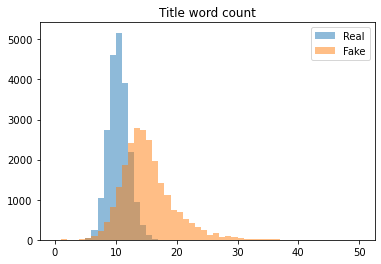

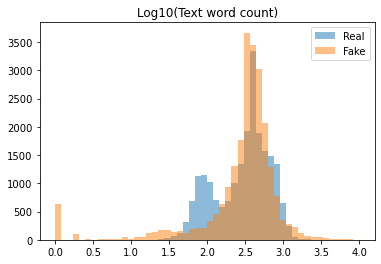

In [6]:
plt.hist(df0.title.str.split().str.len(), alpha=0.5, range=(0,50), bins=50)
plt.hist(df1.title.str.split().str.len(), alpha=0.5, range=(0,50), bins=50)
plt.title("Title word count")

plt.legend(['Real','Fake']) 
plt.show()

plt.hist(np.log10(df0.text.str.split().str.len()+1), alpha=0.5, range=(0,4), bins=50)
plt.hist(np.log10(df1.text.str.split().str.len()+1), alpha=0.5, range=(0,4), bins=50)
plt.title("Log10(Text word count)")

plt.legend(['Real','Fake'])
plt.show()

### Findings
- As notices with raw data examples, fake news has **longer title**.
- Real news contents are written in either around 100 or 400 words, whereas fake news has larger spectrum.
- Some fake news has **few or zero words** in titles and text. Let's take a look what that means.

In [7]:
df0_few_title = df0[df0.title.str.split().str.len()<3]
df1_few_title = df1[df1.title.str.split().str.len()<3]

df0_few_text = df0[df0.text.str.split().str.len()<20]
df1_few_text = df1[df1.text.str.split().str.len()<20]

In [8]:
print('News with title < 3 words, real:',len(df0_few_title))
print('News with title < 3 words, fake:',len(df1_few_title))
print('News with text < 6 words, real:',len(df0_few_text))
print('News with text < 6 words, fake:',len(df1_few_text))

News with title < 3 words, real: 0
News with title < 3 words, fake: 10
News with text < 6 words, real: 1
News with text < 6 words, fake: 1130


In [9]:
print('Empty title examples, fake news\n')
print(df1_few_title.to_numpy())

print('Empty text examples, real news\n')
print(df0_few_text.text.to_numpy())

print('Empty text examples, fake news\n')
print(df1_few_text.text.sample(30, random_state=20).to_numpy())

Empty title examples, fake news

[['https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/'
  'https://100percentfedup.com/served-roy-moore-vietnamletter-veteran-sets-record-straight-honorable-decent-respectable-patriotic-commander-soldier/']
 ['https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/'
  'https://100percentfedup.com/video-hillary-asked-about-trump-i-just-want-to-eat-some-pie/']
 ['https://100percentfedup.com/12-yr-old-black-conservative-whose-video-to-obama-went-viral-do-you-really-love-america-receives-death-threats-from-left/'
  'https://100percentfedup.com/12-yr-old-black-conservative-whose-video-to-obama-went-viral-do-you-really-love-america-receives-death-threats-from-left/']
 ['https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg'
  'https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg']
 ['https://

### Findings
- Fake news is **noiser**.
- **No real news has empty title**
- Fake news with empty/short titles have web addresses as their titles. It looks like an impropper cleaning of web scrapping data.
- Only one real news has few words in text, with graphic content.
- A lot of short fake news composed of **social media sources**.


### To consider in preprocessings (2)
- Drop rows with **website titles**
- Drop one real news **graphic content**
- **Tag digital source**
- **Tag numbers**
- Remove special character after digital source and number tagging.

In [10]:
df1 = df1[df1.title.str.split().str.len()>2]
df0 = df0[df0.text.str.split().str.len()>19]

# Frequent words - Unigram
Before text preprocess, let's take a look of frequent words in raw data.

In [11]:
title0 = df0.sample(1000, random_state=9).title.tolist()
title1 = df1.sample(1000, random_state=9).title.tolist()
text0 = df0.sample(1000, random_state=9).text.tolist()
text1 = df1.sample(1000, random_state=9).text.tolist()

In [12]:
uni_title_real = ngram_tokenizer(title0, n=1)
uni_title_fake = ngram_tokenizer(title1, n=1)
uni_text_real = ngram_tokenizer(text0, n=1)
uni_text_fake = ngram_tokenizer(text1, n=1)

word_counter = Counter(uni_title_real)
print('\n\nMost common words in title, real:\n',word_counter.most_common(500))

word_counter = Counter(uni_title_fake)
print('\n\nMost common words in title, fake:\n',word_counter.most_common(500))

word_counter = Counter(uni_text_real)
print('\n\nMost common words in text, real:\n',word_counter.most_common(100))

word_counter = Counter(uni_text_fake)
print('\n\nMost common words in text, fake:\n',word_counter.most_common(100))



Most common words in title, real:
 [(('to',), 357), (('in',), 190), (('U.S.',), 184), (('Trump',), 183), (('on',), 165), (('of',), 143), (('for',), 141), (('says',), 139), (('with',), 62), (('House',), 61), (('at',), 52), (('over',), 49), (('North',), 48), (('as',), 43), (('after',), 42), (('Korea',), 42), (('White',), 38), (('a',), 36), (('China',), 35), (('from',), 34), (('be',), 32), (('not',), 31), (('Senate',), 31), (('by',), 31), (('and',), 30), (('new',), 30), (('will',), 28), (('U.N.',), 28), (('South',), 27), (('Clinton',), 27), (('the',), 26), (('tax',), 26), (('Russia',), 26), (('calls',), 26), (("Trump's",), 24), (('talks',), 23), (('court',), 22), (('Iran',), 22), (('Congress',), 22), (('Factbox:',), 21), (('Brexit',), 21), (('Republican',), 21), (('president',), 21), (('is',), 20), (('vote',), 20), (('government',), 20), (('opposition',), 20), (('against',), 19), (('ban',), 19), (('party',), 19), (('PM',), 19), (('deal',), 19), (('Obama',), 18), (('EU',), 18), (('nuclea



Most common words in text, fake:
 [(('the',), 20280), (('to',), 12223), (('of',), 9983), (('and',), 9422), (('a',), 8769), (('in',), 6434), (('that',), 5964), (('s',), 5465), (('is',), 4611), (('for',), 3838), (('on',), 3169), (('Trump',), 2777), (('was',), 2741), (('he',), 2582), (('with',), 2579), (('his',), 2395), (('it',), 2290), (('as',), 2184), (('by',), 2070), (('be',), 2039), (('are',), 1924), (('have',), 1829), (('this',), 1825), (('not',), 1756), (('who',), 1747), (('has',), 1727), (('I',), 1711), (('The',), 1670), (('t',), 1641), (('from',), 1599), (('they',), 1545), (('at',), 1512), (('an',), 1428), (('you',), 1373), (('about',), 1344), (('their',), 1215), (('we',), 1089), (('or',), 1019), (('but',), 1015), (('will',), 1008), (('been',), 986), (('would',), 969), (('said',), 946), (('all',), 908), (('were',), 874), (('people',), 858), (('her',), 834), (('out',), 833), (('what',), 814), (('Donald',), 811), (('she',), 785), (('one',), 785), (('more',), 775), (('can',), 766),

### Findings
Following interesting features were found in fake news:
- **"Video"** is one of the most frequent title words
- **Various special charactors** in title
- **Exclamation** marks (!, ?) are frequently used, which make fake news sounds **emotional**.
- **First names** occurs frequently, which is not preferred in real news to be concise. 
- A lot of **"@"** in text, probably they spread fake news by **quoting social media**, like a **rumor** is generated by quoting other person.

### To consider in preprocessings
- Handling **noise, like "'s", "n't"**, without loss of meanings.
- Tag words with **"\*"** charactor (probably a slang, which is not used in real news)
- Capical letters: a little headache about proper noun
    - "U.S." or "U.N." shouldn't be "us" or "un" by removing special characters and lower case.
        - Solution: **"U.S.", "U.N." -> "u_s_", "u_n_"**
    - EU, PM, UK: two charactor words. Should lengthen them.
        - Solution: **"EU" -> e_u_**
    - Change meaning if lower cased: North, South, House, White, State, May ...
        - Context matter. Attention model might work if trained, however, not a first thing to do now.
        - Solution: For now, change frequent words of them manualy. **House -> house_**
- Change **"-" as a space** because it connects two words and you want to keep them spaced.
- Remove other **special charactor**.
- Remove **stop words**





# Frequent words - n Gram

In [13]:
# bigram
bi_title_real = ngram_tokenizer(title0, n=2)
bi_title_fake = ngram_tokenizer(title1, n=2)
bi_text_real = ngram_tokenizer(text0, n=2)
bi_text_fake = ngram_tokenizer(text1, n=2)

print('Bigram =============================\n')

word_counter = Counter(bi_title_real)
print('\n\nMost common words in title, real:\n',word_counter.most_common(500))

word_counter = Counter(bi_title_fake)
print('\n\nMost common words in title, fake:\n',word_counter.most_common(500))

word_counter = Counter(bi_text_real)
print('\n\nMost common words in text, real:\n',word_counter.most_common(100))

word_counter = Counter(bi_text_fake)
print('\n\nMost common words in text, fake:\n',word_counter.most_common(100))

# trigram
tri_title_real = ngram_tokenizer(title0, n=3)
tri_title_fake = ngram_tokenizer(title1, n=3)
tri_text_real = ngram_tokenizer(text0, n=3)
tri_text_fake = ngram_tokenizer(text1, n=3)

print('Trigram =============================\n')

word_counter = Counter(tri_title_real)
print('\n\nMost common words in title, real:\n',word_counter.most_common(500))

word_counter = Counter(tri_title_fake)
print('\n\nMost common words in title, fake:\n',word_counter.most_common(500))

word_counter = Counter(tri_text_real)
print('\n\nMost common words in text, real:\n',word_counter.most_common(100))

word_counter = Counter(tri_text_fake)
print('\n\nMost common words in text, fake:\n',word_counter.most_common(100))

Bigram =============================



Most common words in title, real:
 [(('White', 'House'), 36), (('North', 'Korea'), 32), (('Supreme', 'Court'), 17), (('Trump', 'to'), 16), (('calls', 'for'), 12), (('Puerto', 'Rico'), 11), (('to', 'be'), 10), (('to', 'meet'), 10), (('South', 'Korea'), 9), (('Trump', 'says'), 9), (('says', 'U.S.'), 8), (('travel', 'ban'), 8), (('Trump', 'administration'), 8), (('ahead', 'of'), 8), (('Islamic', 'State'), 8), (('of', 'Trump'), 8), (('for', 'U.S.'), 7), (('in', 'U.S.'), 7), (('to', 'hold'), 7), (('to', 'lead'), 7), (('on', 'North'), 7), (('says', 'he'), 6), (('House', 'says'), 6), (('North', 'Korean'), 6), (('Iran', 'nuclear'), 6), (('aimed', 'at'), 6), (('Trump', 'on'), 6), (('U.S.', 'lawmakers'), 6), (('U.S.', 'Senate'), 6), (('will', 'not'), 5), (('China', 'says'), 5), (('to', 'discuss'), 5), (('to', 'U.S.'), 5), (('House', 'Speaker'), 5), (('in', 'Syria'), 5), (('China', 'to'), 5), (('Reuters/Ipsos', 'poll'), 5), (('to', 'nominate'), 5), (('of', 



Most common words in text, fake:
 [(('of', 'the'), 2241), (('in', 'the'), 1481), (('to', 'the'), 1136), (('on', 'the'), 750), (('to', 'be'), 683), (('that', 'the'), 650), (('for', 'the'), 613), (('Trump', 's'), 565), (('and', 'the'), 558), (('Donald', 'Trump'), 525), (('is', 'a'), 459), (('at', 'the'), 451), (('with', 'the'), 447), (('it', 's'), 436), (('in', 'a'), 433), (('of', 'a'), 431), (('by', 'the'), 399), (('from', 'the'), 397), (('as', 'a'), 390), (('don', 't'), 372), (('that', 'he'), 345), (('has', 'been'), 343), (('is', 'the'), 311), (('going', 'to'), 290), (('the', 'United'), 290), (('It', 's'), 288), (('have', 'been'), 277), (('he', 's'), 269), (('about', 'the'), 264), (('he', 'was'), 259), (('to', 'a'), 258), (('with', 'a'), 247), (('image', 'via'), 246), (('Hillary', 'Clinton'), 244), (('s', 'a'), 233), (('for', 'a'), 233), (('one', 'of'), 232), (('would', 'be'), 229), (('will', 'be'), 228), (('doesn', 't'), 227), (('and', 'his'), 226), (('as', 'the'), 223), (('White', 



Most common words in text, fake:
 [(('the', 'United', 'States'), 162), (('the', 'White', 'House'), 124), (('one', 'of', 'the'), 121), (('Donald', 'Trump', 's'), 117), (('I', 'don', 't'), 106), (('the', 'fact', 'that'), 104), (('Donald', 'J.', 'Trump'), 82), (('of', 'the', 'United'), 75), (('in', 'the', 'United'), 74), (('as', 'well', 'as'), 73), (('a', 'lot', 'of'), 71), (('J.', 'Trump', '(@realDonaldTrump)'), 68), (('21st', 'Century', 'Wire'), 68), (('the', 'New', 'York'), 66), (('in', 'order', 'to'), 66), (('part', 'of', 'the'), 65), (('to', 'be', 'a'), 61), (('New', 'York', 'Times'), 59), (('in', 'front', 'of'), 57), (('and', 'it', 's'), 53), (('according', 'to', 'the'), 53), (('out', 'of', 'the'), 52), (('Hillary', 'Clinton', 's'), 52), (('re', 'going', 'to'), 50), (('said', 'in', 'a'), 50), (('is', 'going', 'to'), 47), (('all', 'of', 'the'), 47), (('it', 'comes', 'to'), 46), (('Black', 'Lives', 'Matter'), 45), (('I', 'm', 'not'), 45), (('Trump', 'and', 'his'), 45), (('going', 't

### Findings
- Some capital letter headache can be solved by using **bigram**. Bigram can select some of proper nouns combined by two common nouns, such as **White House, North Korea**. 

# Features of strong classification power
Some **features** might **occur only** or nearly only in **one class**.
This feature might either give an **insight in modeling** or **dangerous bias** of this specific dataset which has to be removed for generalization of the model. Let's take a look.

### Words that appears (nearly) only in one class.

In [14]:
wc = Counter(uni_title_real)
freq_title_real = [x[0][0] for x in wc.most_common(1000)]

wc = Counter(uni_title_fake)
freq_title_fake = [x[0][0] for x in wc.most_common(1000)]

wc = Counter(uni_text_real)
freq_text_real = [x[0][0] for x in wc.most_common(1000)]

wc = Counter(uni_text_fake)
freq_text_fake = [x[0][0] for x in wc.most_common(1000)]


title_only_in_real = []
for x in freq_title_real:
    if not x in freq_title_fake:
        title_only_in_real.append(x)
        
title_only_in_fake = []
for x in freq_title_fake:
    if not x in freq_title_real:
        title_only_in_fake.append(x)
        
text_only_in_real = []
for x in freq_text_real:
    if not x in freq_text_fake:
        text_only_in_real.append(x)
        
text_only_in_fake = []
for x in freq_text_fake:
    if not x in freq_text_real:
        text_only_in_fake.append(x)
        
print('Number of title words only in real: ', len(title_only_in_real))

print(title_only_in_real[:50])

print('Number of title words only in fake: ', len(title_only_in_fake))

print(title_only_in_fake[:50])

print('Number of text words only in real: ', len(text_only_in_real))

print(text_only_in_real[:50])

print('Number of text words only in fake: ', len(text_only_in_fake))

print(text_only_in_fake[:50])

Number of title words only in real:  889
['says', 'over', 'after', 'Korea', 'China', 'from', 'be', 'new', 'will', 'U.N.', 'South', 'tax', 'calls', "Trump's", 'talks', 'court', 'Factbox:', 'Brexit', 'president', 'vote', 'government', 'opposition', 'against', 'ban', 'party', 'PM', 'deal', 'EU', 'nuclear', 'bill', 'leader', 'minister', 'election', 'military', 'official', 'may', 'attack', 'meet', 'would', 'Syrian', 'Myanmar', 'police', 'border', 'sanctions', 'Tillerson', 'German', 'more', 'plan', 'Puerto', '-']
Number of title words only in fake:  889
['To', 'Of', 'A', 'On', '[Video]', '(VIDEO)', 'And', '[VIDEO]', 'With', 'Is', 'About', 'His', 'Who', 'Trump’s', 'By', 'Just', 'At', 'WATCH:', 'Over', 'He', 'This', 'From', 'Her', 'Was', 'TO', 'TRUMP', 'That', 'Why', 'OF', 'Has', 'THE', 'You', 'Are', 'It', 'Will', 'Him', '–', 'Black', 'Out', 'BREAKING:', 'AND', 'Against', 'OBAMA', 'Have', 'How', 'FOR', 'Their', 'Be', 'Gets', 'Says']
Number of text words only in real:  374
['-', '(Reuters)', 'T

### Findings
- **Title words are surprisingly polarized**, i.e. 89% of words are not overlapping, which explains **why our simple models perform with surprisingly high accuracy**. It turned out that **classification power** mostly comes from **different capitalization rules between real and fake news**. Fake news have too much capitalization, probably to catch attention. We should check this point again after preprocess text.
- Some **international** issues words appear only in real news. However, you can't tell if that's because fake news care more about **domestic politics** or this dataset is **biased**.

### Same thing for bigram

In [15]:
wc = Counter(bi_title_real)
freq_title_real = [x[0] for x in wc.most_common(1000)]

wc = Counter(bi_title_fake)
freq_title_fake = [x[0] for x in wc.most_common(1000)]

wc = Counter(bi_text_real)
freq_text_real = [x[0] for x in wc.most_common(1000)]

wc = Counter(bi_text_fake)
freq_text_fake = [x[0] for x in wc.most_common(1000)]


title_only_in_real = []
for x in freq_title_real:
    if not x in freq_title_fake:
        title_only_in_real.append(x)
        
title_only_in_fake = []
for x in freq_title_fake:
    if not x in freq_title_real:
        title_only_in_fake.append(x)
        
text_only_in_real = []
for x in freq_text_real:
    if not x in freq_text_fake:
        text_only_in_real.append(x)
        
text_only_in_fake = []
for x in freq_text_fake:
    if not x in freq_text_real:
        text_only_in_fake.append(x)
        
print('Number of title words only in real: ', len(title_only_in_real))

print(title_only_in_real[:50])

print('Number of title words only in fake: ', len(title_only_in_fake))

print(title_only_in_fake[:50])

print('Number of text words only in real: ', len(text_only_in_real))

print(text_only_in_real[:50])

print('Number of text words only in fake: ', len(text_only_in_fake))

print(text_only_in_fake[:50])



Number of title words only in real:  987
[('North', 'Korea'), ('calls', 'for'), ('Puerto', 'Rico'), ('to', 'be'), ('to', 'meet'), ('South', 'Korea'), ('Trump', 'says'), ('says', 'U.S.'), ('travel', 'ban'), ('Trump', 'administration'), ('ahead', 'of'), ('Islamic', 'State'), ('for', 'U.S.'), ('in', 'U.S.'), ('to', 'hold'), ('to', 'lead'), ('on', 'North'), ('says', 'he'), ('House', 'says'), ('North', 'Korean'), ('Iran', 'nuclear'), ('aimed', 'at'), ('Trump', 'on'), ('U.S.', 'lawmakers'), ('U.S.', 'Senate'), ('will', 'not'), ('China', 'says'), ('to', 'discuss'), ('to', 'U.S.'), ('House', 'Speaker'), ('China', 'to'), ('Reuters/Ipsos', 'poll'), ('to', 'nominate'), ('of', 'state'), ('U.S.', 'health'), ('nuclear', 'deal'), ('to', 'Trump'), ('of', 'U.S.'), ('Senator', 'McCain'), ('U.S.', 'sanctions'), ('Trump', 'travel'), ('on', 'Trump'), ('finance', 'minister'), ('corruption', 'charges'), ('high', 'court'), ('U.S.', 'House'), ('Speaker', 'Ryan'), ('ruling', 'party'), ('says', 'Trump'), ('Russi

# Conclusion
Keeping in mind of our findings, let's preprocess text data then do another EDA with organized data.